# Tutorial 3: Intrinsic Dimension of Real Images (MNIST)

**Goal:** Estimate the Intrinsic Dimensionality (ID) of a real-world dataset (MNIST) where the ground truth is unknown.

In the previous tutorials, we worked with synthetic data ($X, Y$) where we controlled the generative process. In the real world, we typically have a single dataset $X$. To apply the estimator, we must construct two views ($X_1, X_2$) that share the **intrinsic content** while having independent **nuisance variability**.

In this tutorial, we will explore two fundamental axes of view construction:

1.  **Geometric Splitting:** We split the image spatially (Top/Bottom, Left/Right, Diagonal, Random). We ask: "How much can one part of the image tell us about the rest?" This measures the **Manifold Dimension**.
2.  **Semantic Augmentation:** We use Self-Supervised Learning (SSL) augmentations (Crops, Flips). We ask: "What is the dimension of the content invariant to these transformations?" This measures the **Semantic Dimension**.

We will also introduce:
* **CNN Encoders:** Using Convolutional Networks for image data.
* **Shared Encoders:** Enforcing parameter sharing when views are symmetric. Also known as siamese networks.

In [14]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import os
from scipy.ndimage import gaussian_filter1d, median_filter

from dim_est.run.run_dsib_single_experiment import run_dsib_finite

# Plotting Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams.update({
    "font.family": "serif", "font.serif": "Times New Roman", "mathtext.fontset": "cm",
    'figure.dpi': 100, 'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 14
})

# Smoothing functions
def smooth(arr, sigma=1, med_win=5):
    hist = np.array(arr)
    if len(hist) < 2: return hist
    nan_mask = np.isnan(hist)
    valid_hist = hist[~nan_mask]
    if len(valid_hist) == 0: return hist
    hist[nan_mask] = valid_hist[-1]
    if med_win > 1 and len(hist) >= med_win:
        hist = median_filter(hist, size=med_win, mode='reflect')
    if sigma > 0: hist = gaussian_filter1d(hist, sigma=sigma, mode='reflect')
    hist[nan_mask] = np.nan
    return hist


# Constants
BATCH_SIZE = 128
N_EPOCHS = 50 # For speed in tutorial, real experiments might need more epochs
DATA_PATH = "mnist_data.pt"
SMOOTH_WIN = 5    # Smoothing window
SMOOTH_SIGMA = 1  # Smoothing sigma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Phase 1: Data Preparation

We need to download MNIST and save it as a simple tensor file so the library can load it as an "external" source.

In [12]:
def prepare_mnist(path, max_samples=6000):
    if os.path.exists(path):
        print(f"Data found at {path}")
        return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

prepare_mnist(DATA_PATH)

Data found at mnist_data.pt


### Visualize some of the images:

torch.Size([6000, 1, 28, 28])


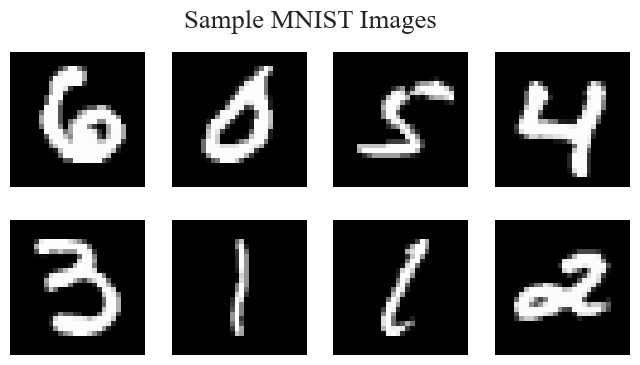

In [13]:
loaded_dataset = torch.load(DATA_PATH)
print(loaded_dataset.shape)  # Should be (max_samples, 1, 28, 28)

# Plot some samples
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(loaded_dataset[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Sample MNIST Images")
plt.show()

## Phase 2: Geometric Splitting (MLPs)

We will compare 5 different splitting strategies:
1.  **Horizontal:** Left Half vs Right Half.
2.  **Vertical:** Top Half vs Bottom Half.
3.  **Diagonal 1:** Main Diagonal Split.
4.  **Diagonal 2:** Anti-Diagonal Split.
5.  **Random:** 50% Random Pixels. We run this 3 times to get error bars.

For all these, we use **MLP Encoders**. Why? Because MLPs are flexible. A diagonal split results in a triangular shape which is hard for standard CNNs, but trivial for an MLP (it's just a vector of pixels).

### Visualize the splits:

In [ ]:
def visualize_tutorial_splits():
    # Load an example image (28x28)
    img = loaded_dataset[0,0]  # Shape: (28, 28)
    H, W = img.shape[1], img.shape[2]

    def get_mask_from_cfg(cfg):
        params = cfg["split_params"]
        strategy = cfg["split_strategy"]
        
        mask = torch.zeros(H, W, dtype=torch.bool)
        
        if strategy == "spatial":
            mode = params.get("mode", "axis")
            
            if mode == "axis":
                axis = params["axis"]
                if axis == 1: # Height (Top vs Bottom)
                    mid = H // 2
                    mask[:mid, :] = True
                elif axis == 2: # Width (Left vs Right)
                    mid = W // 2
                    mask[:, :mid] = True
                    
            elif mode == "diagonal":
                d_dir = params["diagonal_dir"]
                if d_dir == 1: # Main (Upper Triangle)
                    mask = y_grid < x_grid
                else: # Anti (Top-Left Triangle)
                    mask = (y_grid + x_grid) < W
                    
        elif strategy == "random_feature":
            seed = params.get("seed", 42)
            g = torch.Generator().manual_seed(seed)
            perm = torch.randperm(H * W, generator=g)
            idx_x = perm[: (H*W)//2]
            mask.view(-1)[idx_x] = True
            
        return mask

    # 4. Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i, (name, cfg) in enumerate(strategies):
        mask_x = get_mask_from_cfg(cfg)
        mask_y = ~mask_x
        
        # Apply mask
        img_x = dummy_img.clone().squeeze()
        img_x[~mask_x] = 0.0 # Black out Y pixels
        
        img_y = dummy_img.clone().squeeze()
        img_y[~mask_y] = 0.0 # Black out X pixels
        
        # Plot X View
        axes[0, i].imshow(img_x, cmap="viridis", vmin=0, vmax=1)
        axes[0, i].set_title(f"{name}\n(X View)")
        axes[0, i].axis("off")
        
        # Plot Y View
        axes[1, i].imshow(img_y, cmap="viridis", vmin=0, vmax=1)
        axes[1, i].set_title(f"(Y View)")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_tutorial_splits()

In [ ]:
def run_geometric_sweep(split_cfg, name, kz_list=[2, 4, 6, 8, 10, 12, 16]):
    results = []
    for kz in tqdm(kz_list, desc=f"Sweep {name}", leave=False):
        # Use Max-Test Heuristic from Tutorial 2
        traces, _ = run_dsib_finite(
            dataset_type="joint_gaussian", # Dummy type, overridden by external source## NEEDED?
            setup="finite_data_epoch",
            outfile="temp.h5",
            dataset_overrides={
                "source": "external",
                "data_path": DATA_PATH,
                **split_cfg
            },
            critic_type="hybrid",
            critic_overrides={
                "embed_dim": kz,
                "encoder_type": "mlp",
            },
            training_overrides={
                "n_epoch": N_EPOCHS, 
                "show_progress": False,
                "patience": N_EPOCHS
            }
        )
        
        # Robust Estimate: Value at Max Test
        mi_train, mi_test = traces
        smooth_test = smooth(mi_test, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)
        best_epoch = np.argmax(smooth_test)
        robust_val = smooth(mi_train, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)[best_epoch]
        
        results.append({"kz": kz, "mi": robust_val, "strategy": name})
    return results

# Define Strategies
strategies = [
    ("Horizontal", {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}}),
    ("Vertical",   {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}}),
    ("Diag Main",  {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}}),
    ("Diag Anti",  {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}}),
]

all_results = []

# 1. Run Geometric Splits
for name, cfg in strategies:
    res = run_geometric_sweep(cfg, name)
    all_results.extend(res)

# 2. Run Random Splits (3 seeds for error bars)
for seed in [42, 43, 44]:
    cfg = {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": seed}}
    res = run_geometric_sweep(cfg, "Random")
    all_results.extend(res)

Sweep Horizontal:   0%|          | 0/7 [00:00<?, ?it/s]

Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5


Sweep Vertical:   0%|          | 0/7 [00:00<?, ?it/s]

Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5


Sweep Diag Main:   0%|          | 0/7 [00:00<?, ?it/s]

Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5


Sweep Diag Anti:   0%|          | 0/7 [00:00<?, ?it/s]

Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5


Sweep Random:   0%|          | 0/7 [00:00<?, ?it/s]

Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5
Run completed; saved to temp.h5


Sweep Random:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Plotting Geometric Results
df_geo = pd.DataFrame(all_results)

plt.figure()
sns.lineplot(data=df_geo, x="kz", y="mi", hue="strategy", style="strategy", markers=True, dashes=False)
plt.title("Geometric Intrinsic Dimension (MLP Encoders)")
plt.ylabel("Estimated MI (Bits)")
plt.xlabel("Embedding Dimension ($k_Z$)")
plt.show()

### Analysis: Geometry vs Randomness
Does the shape matter? 
* You will likely see that **Random Splits** yield slightly lower MI or looser bounds compared to structured splits (Horizontal/Vertical).
* This is because preserving local pixel correlations (strokes) in the input makes the learning task easier for the encoder.
* The saturation point (where the curve flattens) gives us the **Geometric ID** of MNIST (typically around 10-12 bits).

## Phase 3: Semantic Augmentation (CNNs)

Now we switch gears. Instead of splitting pixels, we create two "views" of the *whole* image using augmentations (Random Crop, Horizontal Flip).

Since the input is now a 2D image (1x28x28), we can use **CNN Encoders**.

We will test two configurations:
1.  **Separate Encoders:** $f_x \neq f_y$ (Standard).
2.  **Shared Encoders:** $f_x = f_y$. Since the views are symmetric (both are "distorted images"), sharing weights should help convergence.

In [ ]:
def run_semantic_sweep(share_encoder, name, kz_list=[2, 4, 6, 8, 10]):
    results = []
    for kz in tqdm(kz_list, desc=f"Sweep {name}", leave=False):
        traces, _ = run_dsib_finite(
            dataset_type="joint_gaussian",
            setup="finite_data_epoch",
            outfile="temp.h5",
            dataset_overrides={
                "source": "external",
                "data_path": DATA_PATH,
                "split_strategy": "augment",
                "split_params": {"transform_spec": "crop_flip"}
            },
            critic_type="hybrid",
            critic_overrides={
                "embed_dim": kz,
                "share_encoder": share_encoder,
                # Configure CNN Encoder
                "encoder_type": "cnn",
                "encoder_kwargs": {
                    "input_channels": 1,
                    "channels": [16, 32] # Small CNN for MNIST
                }
            },
            training_overrides={
                "n_epoch": N_EPOCHS, 
                "show_progress": False,
                "patience": 10
            }
        )
        
        # Robust Estimate
        mi_train, mi_test = traces
        smooth_test = pd.Series(mi_test).rolling(5, min_periods=1).mean()
        best_epoch = np.argmax(smooth_test)
        robust_val = mi_train[best_epoch]
        
        results.append({"kz": kz, "mi": robust_val, "strategy": name})
    return results

sem_results = []

# Run Shared vs Separate
sem_results.extend(run_semantic_sweep(True, "Shared CNN"))
sem_results.extend(run_semantic_sweep(False, "Separate CNN"))

In [ ]:
df_sem = pd.DataFrame(sem_results)

plt.figure()
sns.lineplot(data=df_sem, x="kz", y="mi", hue="strategy", marker="o")
plt.title("Semantic Intrinsic Dimension (CNN Encoders)")
plt.ylabel("Estimated MI (Bits)")
plt.xlabel("Embedding Dimension ($k_Z$)")
plt.show()

### Conclusion

In this tutorial, we demonstrated the library's ability to handle raw image data and advanced splitting strategies.

1.  **Geometric Splits:** We found that regardless of how we slice the image (Top/Bottom, Diagonal), the estimator converges to a consistent **Geometric ID**.
2.  **Semantic Augmentation:** By using CNNs and augmentations, we estimated the information content that is *invariant* to affine transformations.
3.  **Architecture:** We showed how to swap MLPs for CNNs and enable Parameter Sharing to improve estimation efficiency.

The estimates you see here (likely < 12 bits) are orders of magnitude smaller than the pixel space ($28 \times 28 = 784$), confirming that MNIST digits lie on a very low-dimensional manifold.